# Project One - Multi Linear Regression
Techstack:tensorflow, pandas

Data: kaggle

In [60]:
# Import Modules

import kagglehub
import os
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error

In [47]:
path = kagglehub.dataset_download("nikhil7280/student-performance-multiple-linear-regression")

In [48]:
# Find CSV files in the directory
files = os.listdir(path)
csv_files = [f for f in files if f.endswith('.csv')]

if csv_files:
    # Load the first CSV file found
    csv_file = csv_files[0]
    csv_path = os.path.join(path, csv_file)
    df = pd.read_csv(csv_path)
    print(f"Loaded {csv_file}")
    print(df.head())

Loaded Student_Performance.csv
   Hours Studied  Previous Scores Extracurricular Activities  Sleep Hours  \
0              7               99                        Yes            9   
1              4               82                         No            4   
2              8               51                        Yes            7   
3              5               52                        Yes            5   
4              7               75                         No            8   

   Sample Question Papers Practiced  Performance Index  
0                                 1               91.0  
1                                 2               65.0  
2                                 2               45.0  
3                                 2               36.0  
4                                 5               66.0  


In [49]:
#  Basic cleaning / column selection
target = "Performance Index"
features = [
    "Hours Studied",
    "Previous Scores",
    "Extracurricular Activities",   # often 0/1
    "Sleep Hours",
    "Sample Question Papers Practiced"
]
X = df[features].copy()
y = df[target].astype(float)

# If Extracurricular Activities is 'Yes'/'No', convert to 1/0:
if X["Extracurricular Activities"].dtype == object:
    X["Extracurricular Activities"] = X["Extracurricular Activities"].str.strip().str.lower().map({"yes":1, "no":0})



In [50]:
# Train/val/test split
X_train, X_temp, y_train, y_temp = train_test_split(X.values, y.values, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test   = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)


### Multi Linear Regression Explanation

- **Model (5 predictors):**

$$
\hat{y} \;=\; \beta_0 \;+\; \sum_{j=1}^{5} \beta_j\, x_j,
\qquad X \in \mathbb{R}^{n \times 5}.
$$

- **Ridge loss (objective):**

$$
\boxed{
L(\beta_0,\boldsymbol{\beta})
=\frac{1}{n}\sum_{i=1}^{n}
\big(y_i - \beta_0 - \mathbf{x}_i^\top \boldsymbol{\beta}\big)^2
\;+\;
\lambda\,\lVert \boldsymbol{\beta} \rVert_2^2
}
$$

- **Notes:** L2 is applied to the weights $\boldsymbol{\beta}$ (kernel) **not** the bias $\beta_0$.


In [51]:
normalizer = tf.keras.layers.Normalization()
normalizer.adapt(X_train)             # fit on train only

In [52]:
# Ridge strength 
lambda_l2 = 1e-3

inputs  = keras.Input(shape=(5,))
x = normalizer(inputs)
outputs = layers.Dense(1, activation=None, kernel_regularizer=keras.regularizers.l2(lambda_l2))(x)
model = keras.Model(inputs, outputs)

In [53]:
model.compile(optimizer="adam", loss="mse")

model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=300, verbose=0)


TypeError: cannot unpack non-iterable float object

In [62]:
model.evaluate(X_test, y_test, verbose=0)

4.43940544128418

In [54]:


model.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 5)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ normalization (Normalization)   │ (None, 5)              │            11 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │             6 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 31 (132.00 B)

 Trainable params: 6 (24.00 B)

 Non-trainable params: 11 (48.00 B)

 Optimizer params: 14 (60.00 B)

In [56]:
W, b = model.layers[-1].get_weights()      
means = normalizer.mean.numpy()      
stds  = np.sqrt(normalizer.variance.numpy())  

print("Weights:", W)
print("Bias:", b)
print("Means:", means)
print("Stds:", stds)

Weights: [[ 7.413066  ]
 [17.588448  ]
 [ 0.28782532]
 [ 0.818672  ]
 [ 0.5435473 ]]
Bias: [55.40099]
Means: [[ 4.9845715  69.60257     0.49028572  6.542       4.6197143 ]]
Stds: [[ 2.5963252  17.339172    0.49990562  1.6967049   2.867644  ]]


R^2: 0.9889 | MAE: 1.6129 | RMSE: 4.0741


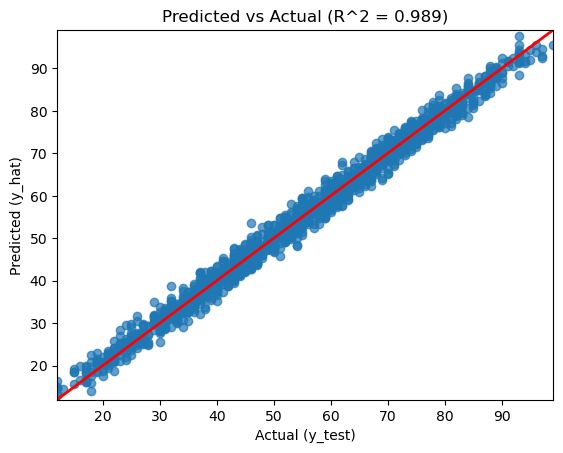

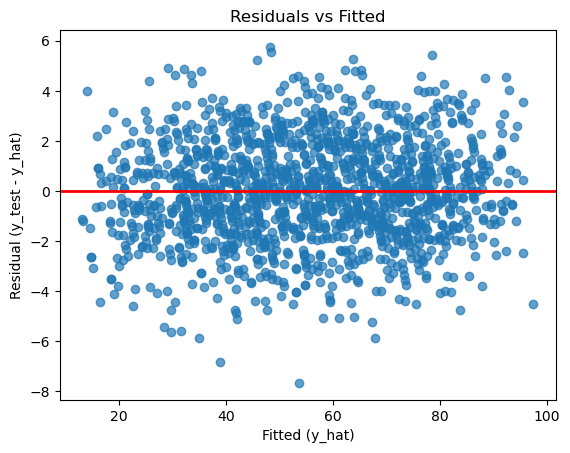

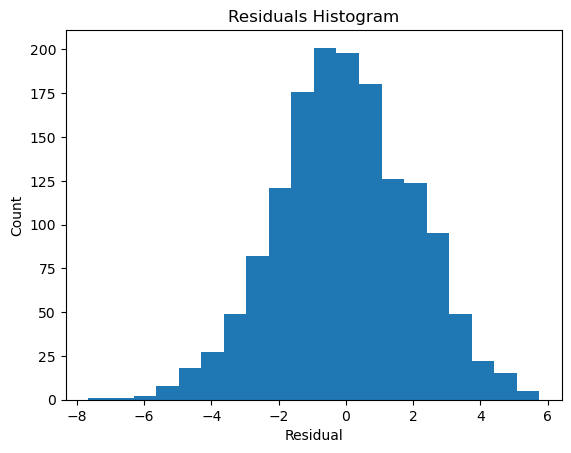

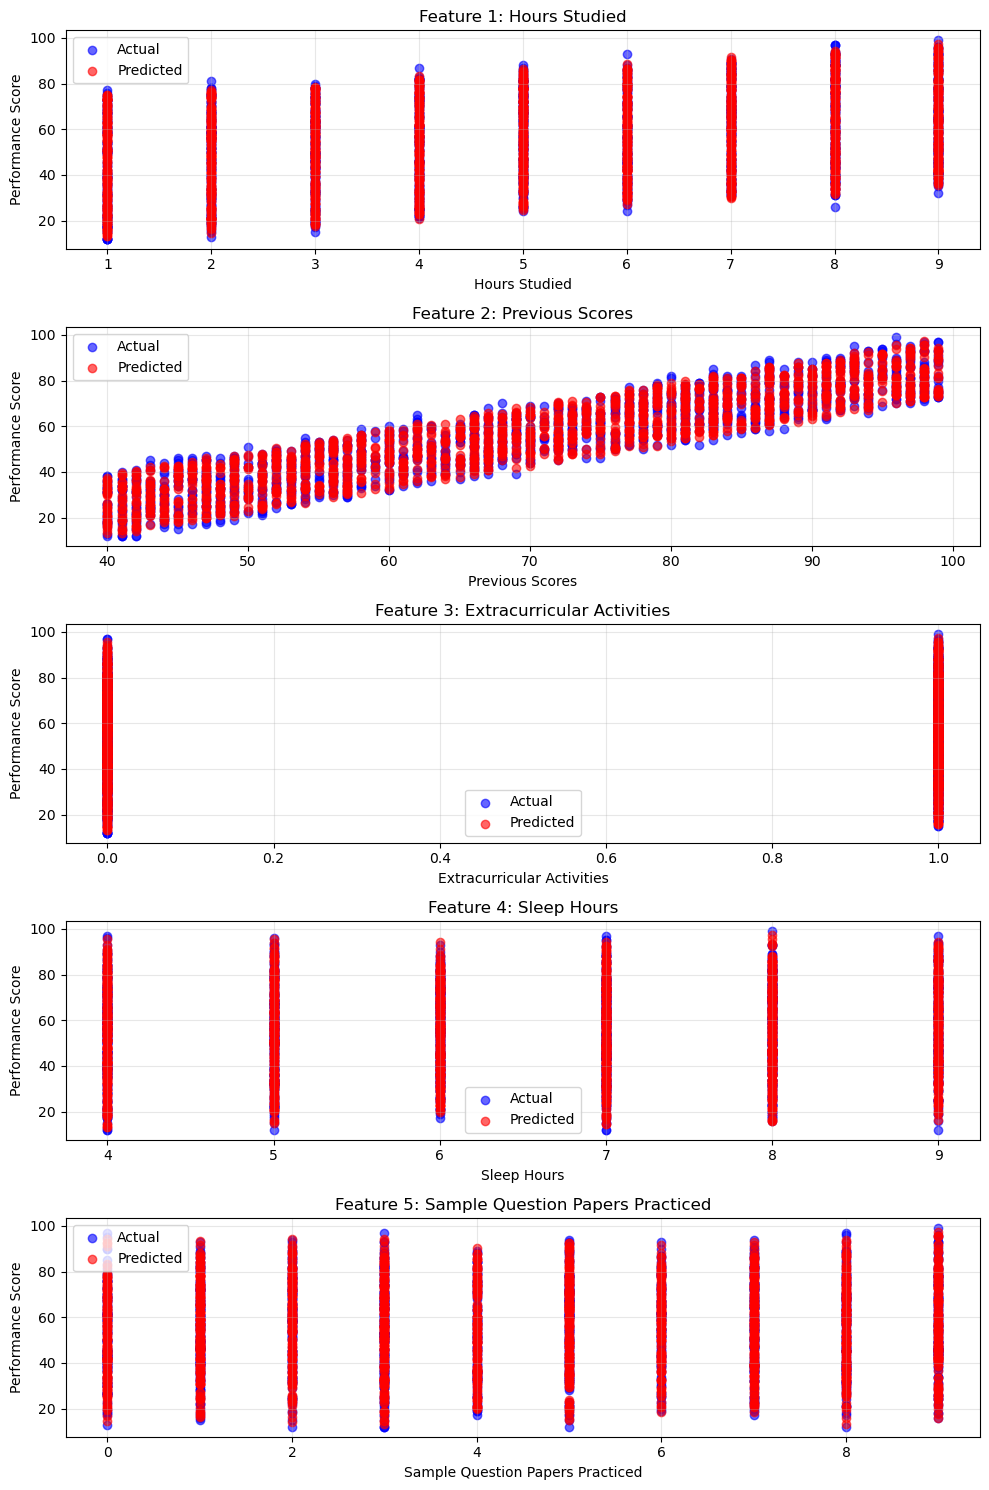

In [69]:
y_pred = model.predict(X_test, verbose=0).squeeze()

r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred)
print(f"R^2: {r2:.4f} | MAE: {mae:.4f} | RMSE: {rmse:.4f}")

# ---- 1) Predicted vs Actual ----
plt.figure()
plt.scatter(y_test, y_pred, alpha=0.7)
lo, hi = min(y_test.min(), y_pred.min()), max(y_test.max(), y_pred.max())
plt.plot([lo, hi], [lo, hi], linewidth=2, color="red")  # 45° reference line
plt.xlabel("Actual (y_test)")
plt.ylabel("Predicted (y_hat)")
plt.title(f"Predicted vs Actual (R^2 = {r2:.3f})")
plt.xlim(lo, hi); plt.ylim(lo, hi)
plt.show()

# ---- 2) Residuals vs Fitted ----
resid = y_test - y_pred
plt.figure()
plt.scatter(y_pred, resid, alpha=0.7)
plt.axhline(0.0, linewidth=2, color="red")
plt.xlabel("Fitted (y_hat)")
plt.ylabel("Residual (y_test - y_hat)")
plt.title("Residuals vs Fitted")
plt.show()

# ---- 3) Residual Histogram ----
plt.figure()
plt.hist(resid, bins=20)
plt.xlabel("Residual")
plt.ylabel("Count")
plt.title("Residuals Histogram")
plt.show()

# ---- 4) Per-feature scatter: each X_j vs y_test and y_hat (one plot per feature) ----
n_features = X_test.shape[1]
fig, axes = plt.subplots(n_features, 1, figsize=(10, 3*n_features))
if n_features == 1:
    axes = [axes]

for i in range(n_features):
    ax = axes[i]
    
    ax.scatter(X_test[:, i], y_test, alpha=0.6, color='blue', label='Actual')
    ax.scatter(X_test[:, i], y_pred, alpha=0.6, color='red', label='Predicted')
    
    ax.set_xlabel(f'{features[i] if i < len(features) else f"Feature {i+1}"}')
    ax.set_ylabel('Performance Score')
    ax.set_title(f'Feature {i+1}: {features[i] if i < len(features) else f"Feature {i+1}"}')
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


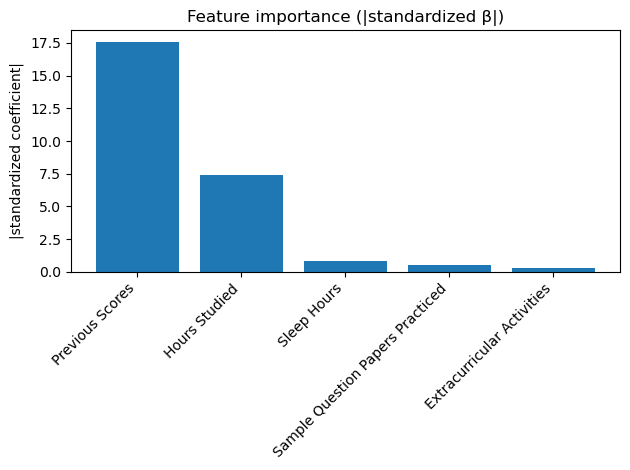

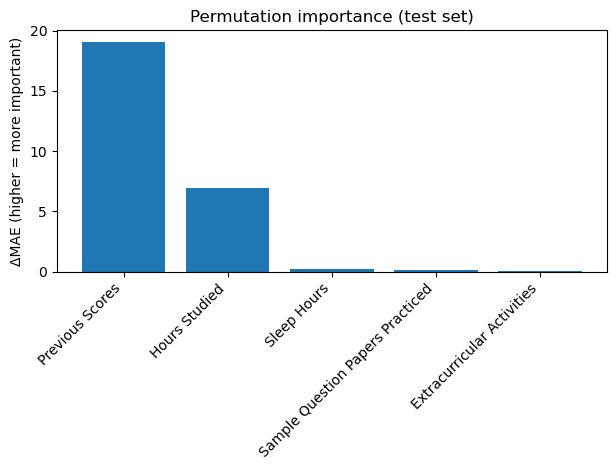

In [70]:


def _get_dense_weights(model):
    dense = next(l for l in model.layers if isinstance(l, tf.keras.layers.Dense))
    W, b = dense.get_weights()  # W: (n_features,1), b: (1,)
    return W[:, 0], b[0]

def plot_coef_importance(model, X_train, feature_names, normalizer=None, title="Feature importance (|standardized β|)"):
    """Bar chart of |standardized coefficients| (scale-invariant)."""
    W, _ = _get_dense_weights(model)

    if normalizer is not None:
        # Inputs already standardized by the layer → weights correspond to 1 SD change
        importance = np.abs(W)
    else:
        # Standardize post-hoc: β_std = β * std(X)
        Xn = np.asarray(X_train)
        stds = Xn.std(axis=0, ddof=0)
        importance = np.abs(W * stds)

    order = np.argsort(-importance)
    names_sorted = np.array(feature_names)[order]
    vals_sorted = importance[order]

    plt.figure()
    plt.bar(np.arange(len(vals_sorted)), vals_sorted)
    plt.xticks(np.arange(len(vals_sorted)), names_sorted, rotation=45, ha="right")
    plt.ylabel("|standardized coefficient|")
    plt.title(title)
    plt.tight_layout()
    plt.show()

def permutation_importance(model, X, y, feature_names, n_repeats=10, random_state=42):
    """Permutation importance on the test set: ΔMAE when shuffling each feature."""
    rng = np.random.default_rng(random_state)
    X = np.asarray(X).copy()
    y = np.asarray(y).squeeze()

    base_pred = model.predict(X, verbose=0).squeeze()
    base_mae = mean_absolute_error(y, base_pred)

    deltas = []
    for j in range(X.shape[1]):
        scores = []
        for _ in range(n_repeats):
            Xp = X.copy()
            rng.shuffle(Xp[:, j])
            pred = model.predict(Xp, verbose=0).squeeze()
            scores.append(mean_absolute_error(y, pred) - base_mae)
        deltas.append(np.mean(scores))

    deltas = np.array(deltas)
    order = np.argsort(-deltas)
    names_sorted = np.array(feature_names)[order]
    vals_sorted  = deltas[order]

    plt.figure()
    plt.bar(np.arange(len(vals_sorted)), vals_sorted)
    plt.xticks(np.arange(len(vals_sorted)), names_sorted, rotation=45, ha="right")
    plt.ylabel("ΔMAE (higher = more important)")
    plt.title("Permutation importance (test set)")
    plt.tight_layout()
    plt.show()


# -------- Use the functions --------
plot_coef_importance(model, X_train, features, normalizer=normalizer)
permutation_importance(model, X_test, y_test, features)
